# 1. LLE

## Step 0. 필수 라이브러리 불러오기 및 실험용 데이터 불러오기

각 과정에 대한 설명은 Readme 참고

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml # MNIST dataset

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

In [5]:
MNIST = fetch_openml('mnist_784').data
MNIST_label = fetch_openml('mnist_784').target

In [6]:
data=MNIST[::1000]
label=MNIST_label[::1000]

## Step 1. 각 데이터 포인트의 이웃을 할당한다.
LLE의 첫번째 step은 앞선 Readme에서 설명한 바와 같이 각 데이터 포인트에 이웃을 할당하는 것이다.  
가장 먼저 이웃 할당 여부를 결정하기 위한 distance-metric을 결정하고 e-neighbourhood, K-nearest neighbors, locality sensitive hashing 등의 방법론 들을 통해 이웃을 할당한다.  

본 실습에서는 우선 euclidean_distances를 사용하여 K-nearest neighbors를 구하고 마지막에 manhattan_distances를 사용한 결과와 비교하고자한다.

In [28]:
# 데이터 X에 대해 distance metric을 기준으로 K-nearest neighbors 산출, dist는 해당 거리
def get_neighbors(data, k, distance='euclidean'): 
    if distance == 'euclidean':
        dist = euclidean_distances(data)
    elif distance == 'manhattan':
        dist = manhattan_distances(data)
    
    indices= dist.argsort(axis=1)
    # dist = np.sort(dist, axis=1)
    # dist = dist[:, 1:k+1]
    indices = indices[:, 1:k+1]
    return indices#, dist

In [29]:
k_euclidean=get_neighbors(data, 5, distance='euclidean')
k_euclidean

array([[33, 45, 10, 25, 52],
       [ 6, 38, 27, 44,  3],
       [59, 48,  1, 27,  3],
       [ 1, 18,  2, 44, 47],
       [40, 12, 61, 25, 69],
       [23, 18, 37, 66, 39],
       [62, 11, 59, 63, 31],
       [45, 56, 22, 46, 50],
       [47, 44,  1,  3, 31],
       [57, 37,  8, 19, 58],
       [45, 33, 30, 22, 65],
       [59,  6, 62, 52, 63],
       [60,  4, 58, 38, 69],
       [60, 26, 48, 14, 21],
       [35, 28, 42, 22, 67],
       [54, 27, 65, 63, 33],
       [19, 24, 32, 38, 36],
       [30, 65, 50, 10, 22],
       [34, 66, 39, 48,  3],
       [16, 24,  4, 32, 50],
       [31, 27, 15, 44, 47],
       [14, 46, 26, 25, 13],
       [14, 35, 42, 30, 56],
       [51,  5, 66, 60, 18],
       [19, 32, 16, 38, 50],
       [61, 14, 28, 21, 26],
       [48, 13, 62, 21, 46],
       [15, 20,  1, 30, 31],
       [35, 14, 42, 67, 56],
       [26, 67, 55, 56, 42],
       [22, 65, 10, 67, 14],
       [20,  6, 27,  1, 15],
       [24, 38, 16, 62, 50],
       [45, 10, 22, 65,  0],
       [18, 46

In [30]:
#manhattan 거리 기준 이웃
k_manhattan=get_neighbors(data, 5, distance='manhattan')

## Step 2. 할당된 이웃들을 활용하여 중심의 데이터를 표현하기 위한 최적의 가중치를 찾는다.

In [31]:
def get_W(data, neighbors):
    W = np.zeros((data.shape[0],data.shape[0]))
    W_n = np.zeros((neighbors.shape[0],neighbors.shape[1]))
    for i in range(data.shape[0]):
        x_neighbor = data.iloc[neighbors[i],:]

        e=x_neighbor- np.kron(np.ones((neighbors.shape[1], 1)), data.iloc[i, :])
        mse=np.dot(e, e.T)
        mse = mse+np.identity(neighbors.shape[1]) + 1e-3*np.trace(mse)

        W_n[i,:] = np.linalg.solve(mse, np.ones((neighbors.shape[1],1)))[:,0]
        W_n[i,:] = W_n[i,:] / np.sum(W_n[i,:]) #합이 1 되도록 정규화

    for i in range(data.shape[0]):
        neighbors_index = neighbors[i]
        for j, k in enumerate(neighbors_index):
            W[i][k] = W_n[k][j]
    return W

In [32]:
W=get_W(data, k_euclidean)

## Step 3. 새로 얻은 가중치 행렬 𝑊_𝑖𝑗 를 활용하여 축소된 차원으로 데이터를 표현한다.
비교를 위한 시각화를 위해 여기에선 2차원으로 축소하였다.


In [33]:
def get_lower_y(data, lowerDemsion, Weight):
    #readme에서 목적함수를 정리한 결과 M = (I-W)'(I-W)이므로
    M = np.matmul(np.transpose(np.identity(data.shape[0], dtype=float)-W),(np.identity(data.shape[0], dtype=float)-W))
    eigne_values, eigen_vectors = np.linalg.eig(M)
    
    #eigen value가 가장 작은것은 모든 객체에대해 unit vector이므로 제외
    componet = np.argsort(eigne_values)[1:lowerDemsion+1]
    lower_y = eigen_vectors[:,componet]*np.sqrt(data.shape)
    
    return lower_y

In [34]:
y=get_lower_y(data,2, W)
y

array([[-0.40398742, -0.21340057],
       [ 0.75975171, -1.3890481 ],
       [ 1.29060338, -1.91177515],
       [ 0.38523282, -1.38259931],
       [-2.0902948 ,  5.3582267 ],
       [-0.57737641, -4.06139289],
       [ 1.82180633, -1.14875269],
       [-0.25602601, -2.03988019],
       [ 0.58930695, -2.09854379],
       [ 0.0404264 , -2.46733084],
       [-0.26772901, -0.49381707],
       [ 2.2794009 , -1.29926504],
       [-1.06344829,  3.00730217],
       [-0.79471348, -0.34213522],
       [-0.38773415, -0.17337256],
       [ 0.01346802, -3.3955047 ],
       [ 1.24677262,  5.44334316],
       [-0.20955265, -0.56561682],
       [-0.88294765, -6.80064288],
       [ 1.26850498,  5.53763104],
       [ 0.50176479, -2.07283883],
       [-0.96058395, -1.96782452],
       [-0.32840063, -0.12361916],
       [-0.80231632, -4.84619951],
       [ 1.23676244,  4.57416144],
       [-0.90297647,  1.13446096],
       [-0.38813926, -1.60654091],
       [ 0.30567413, -2.37194771],
       [-0.30007242,

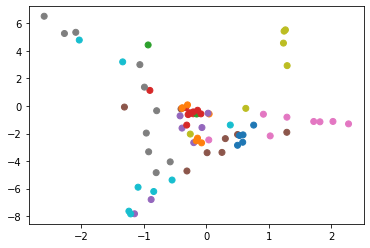

In [35]:
# 검증을 위한 시각화
#각 색이 각각 다른 숫자를 의미
plt.scatter(y[:,0], y[:,1], c=label.astype(int), cmap='tab10')

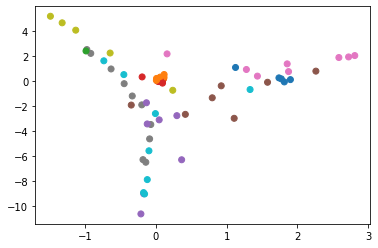

In [36]:
k_manhattan=get_neighbors(data, 5, distance='manhattan')
W=get_W(data, k_manhattan)
y=get_lower_y(data,2, W)
plt.scatter(y[:,0], y[:,1], c=label.astype(int), cmap='tab10')

## 다양한 Hyperparameter 비교 실험

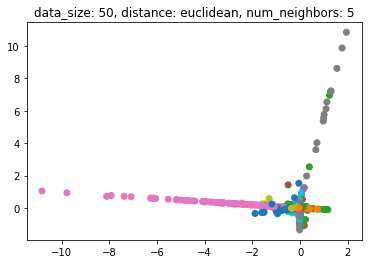

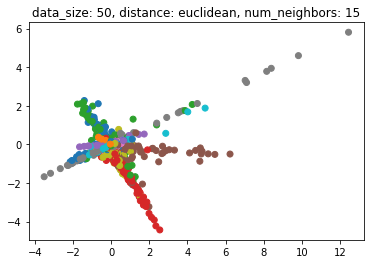

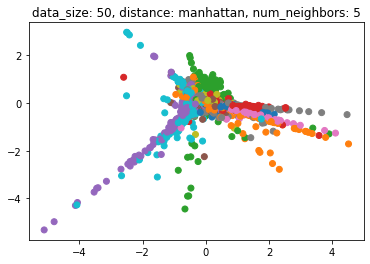

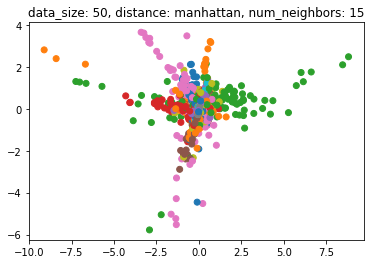

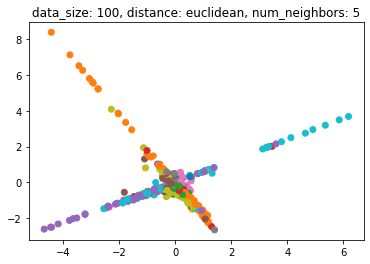

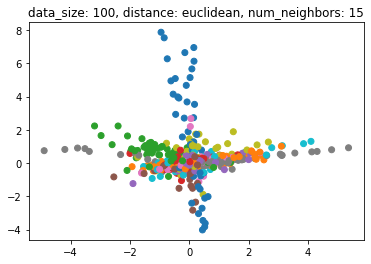

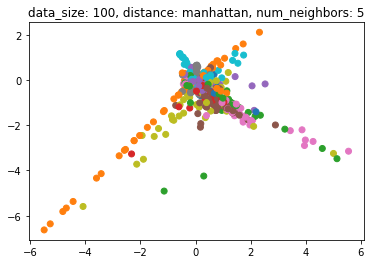

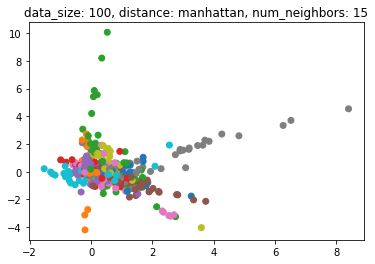

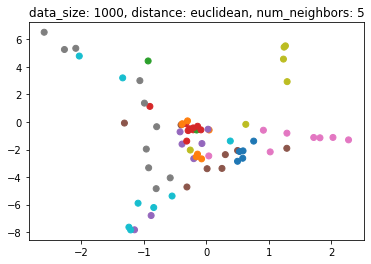

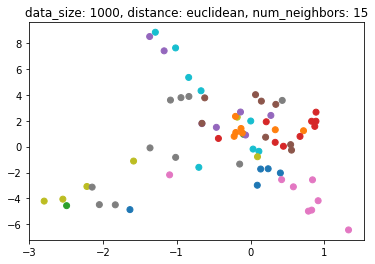

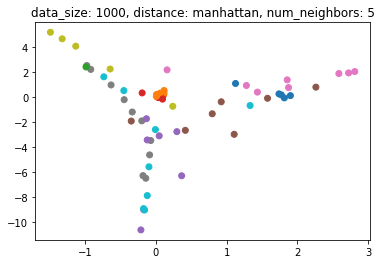

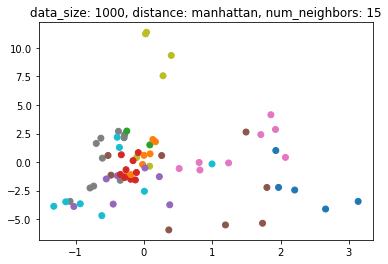

In [39]:
data_size = [50, 100, 1000] #각각 mnist에서 1/50, 1/100, 1/1000개의 데이터를 사용
distance=['euclidean', 'manhattan']
num_neighbors=[5, 15]

for i in data_size:
    data=MNIST[::i]
    label=MNIST_label[::i]
    for j in distance:
        for k in num_neighbors:
            k_neighbors=get_neighbors(data, k, distance=j)
            W=get_W(data, k_neighbors)
            y=get_lower_y(data,2, W)
            plt.scatter(y[:,0], y[:,1], c=label.astype(int), cmap='tab10')
            plt.title('data_size: 1/{}, distance: {}, num_neighbors: {}'.format(i,j,k))
            plt.show()


# 2. t-SNE

In [134]:
#각 객체간의 거리를 계산하기 위한 라이브러리 사용
from scipy.spatial.distance import pdist, squareform
from scipy.special import softmax

In [135]:
distance_M = squareform(pdist(data, metric='euclidean'))
distance_M

array([[   0.        , 2533.23666482, 2571.45717444, ..., 2373.42158076,
        3221.93358094, 2565.07836138],
       [2533.23666482,    0.        , 2182.26671147, ..., 2488.44007362,
        2904.81221424, 2762.525475  ],
       [2571.45717444, 2182.26671147,    0.        , ..., 2565.75485969,
        2725.76888235, 2895.59510291],
       ...,
       [2373.42158076, 2488.44007362, 2565.75485969, ...,    0.        ,
        3162.15085029, 2460.65377491],
       [3221.93358094, 2904.81221424, 2725.76888235, ..., 3162.15085029,
           0.        , 2914.37180195],
       [2565.07836138, 2762.525475  , 2895.59510291, ..., 2460.65377491,
        2914.37180195,    0.        ]])

In [136]:
# SNE의 이웃할 확률을 구한다.P:sigma사용, Q:sigma사용x
def get_P_matrix(distance_M, sigma):
    return softmax(distance_M / 2. * np.square(sigma.reshape((-1, 1))),axis=1)

def get_Q_matrix(distance_M):
    return softmax(distance_M,axis=1)

In [137]:
# 일정한 수의 이웃 수를 유지하기 위해 perplexity가 정해졌을 때 sigma를 구한다.
def find_sigma_for_perplexity(distance_M,perplexity):
    N = distance_M.shape[0]
    SIGMA = np.zeros(N)
    for i in range(N):
        for s in range(0,100): #sigma의 범위를 0~100/10으로 설정
            sigma= np.array([(s+1)/10]*N)
            p_i = get_P_matrix(distance_M,sigma)[i]
            H = 0
            for j in range(N):
                if p_i[j]!=0:
                    H += -p_i[j]*np.log2(p_i[j]) #현재 sigma에서의 entropy
            perplexity_hat = 2**H #현재의 perplexity
            if np.abs(perplexity-perplexity_hat)<3: #목표로하는 perplexity와 현재의 perplexity의 차이가 1보다 작으면 break
                SIGMA[i] = sigma[i]
                break
    return SIGMA

In [138]:
sigma=find_sigma_for_perplexity(distance_M,30)
sigma

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
       0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0.1, 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
       0. , 0. , 0. , 0. , 0.1])

In [206]:
# t-SNE를 계산하기 위해 각각의 각각의 차원에서 SNE를 계산한다.
# 고차원에서의 P를 구한다.
def get_symmetric_P(distance_M,sigma):

    N = distance_M.shape[0]
    P = get_P_matrix(distance_M,sigma)
    Pij=np.zeros((N,N))
    for i in range(0,N-1):
        for j in range(i+1,N):
            Pij[i,j] = (P[i,j]+P[j,i])/(2*N)
            Pij[j,i] = Pij[i,j]
    return Pij
    
# 저차원에서의 Q를 구한다.
def get_symmetric_Q(distance_M):

    N = distance_M.shape[0]
    Q = get_Q_matrix(distance_M)

    Qij=np.zeros((N,N))
    for i in range(0,N-1):
        for j in range(i+1,N):
            Qij[i,j] = (Q[i,j]+Q[j,i])/(2*N)
            Qij[j,i] = Qij[i,j]

    return Qij

In [207]:
# 공식에서 얻은 gradient를 그대로 활용하여 t-SNE계산을 위한 KL divergence의 gradient를 계산한다.
def get_gradientOf_Cost(Y,distance_Y,P,Q):
    N = distance_Y.shape[0]
    grad = np.zeros((N,2))
    for i in range(N):
        dy=0
        for j in range(N):
            dy += 4*(Y[i]-Y[j])*(P[i,j]-Q[i,j])/(1+(distance_Y[i,j])**2)
        grad[i,:]=dy

    return grad

In [208]:
# 실험을 위한 데이터는 LLE와 동일한 것을 사용
# data=pd.DataFrame.to_numpy(data)
# label=MNIST_label[::1000]
#sigma 탐색 및 P계산
sigma=find_sigma_for_perplexity(distance_M,30) # 이론상 perplexity는 유연
P=get_symmetric_P(distance_M,sigma)
#Y 초기화
Y = np.random.rand(distance_M.shape[0],2) # 시각화 위해 2차원으로 설정
distance_Y=squareform(pdist(Y, metric='euclidean'))
Q = get_symmetric_Q(distance_Y)

0.9999999999999982


0


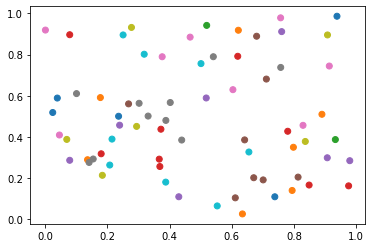

100


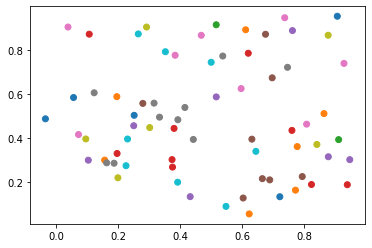

200


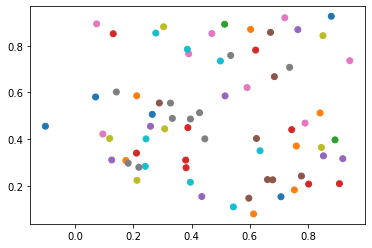

300


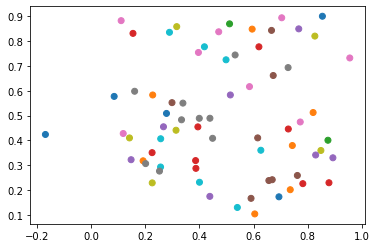

400


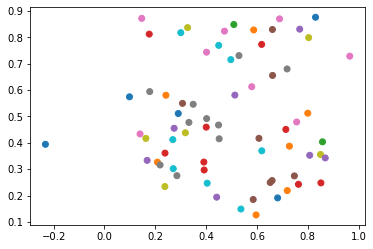

500


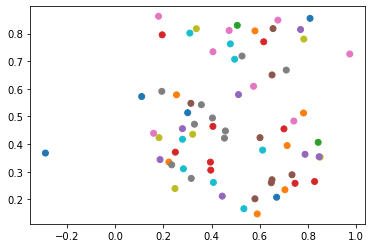

600


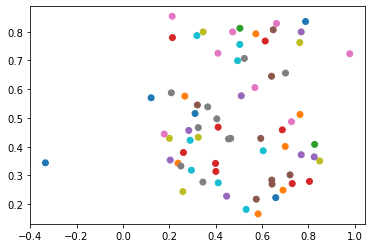

700


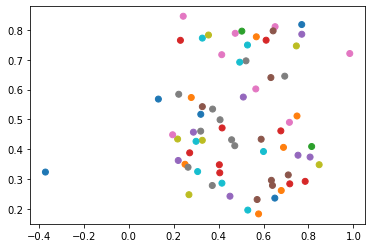

800


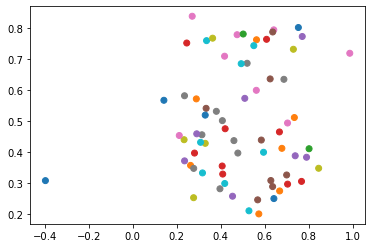

900


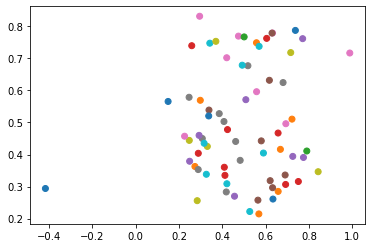

In [209]:
#학습 + 시각화 포함
learning_rate = 0.1
momentum=0.5
for i in range(1000):
    grad = get_gradientOf_Cost(Y,distance_Y,P,Q)
    Y_ = Y
    Y = Y_ + learning_rate*grad + momentum*(Y-Y_)
    distance_Y=squareform(pdist(Y, metric='euclidean'))
    Q = get_symmetric_Q(distance_Y)
    
    if i%100==0:
        print(i)
        plt.scatter(Y[:,0],Y[:,1],c=label.astype(int), cmap='tab10')
        plt.show()
